<a href="https://colab.research.google.com/github/bhadreshpsavani/EfficientQAExperiments/blob/master/Drop__1_text_summary_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# !pip3 install os
from os import listdir
import string
from pickle import dump,load

## Step1. Amazon Food reviews Dataset

In [2]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 576.1 kB/s eta 0:00:00


## Imports

In [3]:
!pip install bs4
!pip install tensorflow
!pip install keras

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=239ba959fbc44efa73b0e26ea0c4d8c8001d32ea6b9566f4d3c16015d159e190
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [4]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Embedding, LSTM, Dense, TimeDistributed, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

import tensorflow as tf
import time
from os import listdir
import string
from pickle import dump,load
import pickle
from keras.callbacks import ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/cnn_dailymail")

AMAZON_DATA_PATH= '/content/drive/MyDrive/cnn_dailymail/Reviews.csv'

Mounted at /content/drive


In [6]:
class Load_amazon_data:

    def __init__(self, dir_path, seed= 0):
        """
        Initialization
        """
        self.dir_path= dir_path
        np.random.seed(seed)

    def load(self):
        """
        Reads data from the given directory path
        """
        return pd.read_csv(self.dir_path)

    def drop(self):
        """
        Drops unnecessary columns
        """

        data= self.load()

        data = data.dropna()
        data= data.iloc[:, -2:]
        data = data.reset_index(drop= True)

        return data

    def analyze_data(self):
        """
        Prints some sample data points from the cleaned data
        """
        data= self.drop()

        for sr_no, i in enumerate(np.random.randint(10, 100, size= 5)):
            print("_________________________")
            print("Data Point {0}".format(sr_no + 1))
            print("Summary:")
            print(data['Summary'].iloc[i])
            print("Full Text:")
            print(data['Text'].iloc[i])

In [7]:
obj= Load_amazon_data(AMAZON_DATA_PATH, seed= 1)

## Load the Data

In [8]:
data= obj.load()
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


## Dropping Unnecessary columns

In [9]:
data= obj.drop()
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568411 entries, 0 to 568410
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Summary  568411 non-null  object
 1   Text     568411 non-null  object
dtypes: object(2)
memory usage: 8.7+ MB


In [17]:
data = data.sample(20000)

## Step 2: Cleaning the Data

In [18]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
  for row in column:
    row = re.sub("(\\t)", " ", str(row)).lower()
    row = re.sub("(\\r)", " ", str(row)).lower()
    row = re.sub("(\\n)", " ", str(row)).lower()

    # Remove _ if it occurs more than one time consecutively
    row = re.sub("(__+)", " ", str(row)).lower()

    # Remove - if it occurs more than one time consecutively
    row = re.sub("(--+)", " ", str(row)).lower()

    # Remove ~ if it occurs more than one time consecutively
    row = re.sub("(~~+)", " ", str(row)).lower()

    # Remove + if it occurs more than one time consecutively
    row = re.sub("(\+\++)", " ", str(row)).lower()

    # Remove . if it occurs more than one time consecutively
    row = re.sub("(\.\.+)", " ", str(row)).lower()

    # Remove the characters - <>()|&©ø"',;?~*!
    row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

    # Remove mailto:
    row = re.sub("(mailto:)", " ", str(row)).lower()

    # Remove \x9* in text
    row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

    # Replace INC nums to INC_NUM
    row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

    # Replace CM# and CHG# to CM_NUM
    row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

    # Remove punctuations at the end of a word
    row = re.sub("(\.\s+)", " ", str(row)).lower()
    row = re.sub("(\-\s+)", " ", str(row)).lower()
    row = re.sub("(\:\s+)", " ", str(row)).lower()
    row = re.sub(r'https?:\/\/.*[\r\n]*', '', str(row), flags=re.MULTILINE)
    row = re.sub(r'\<a href', ' ', str(row))
    row = re.sub(r'&amp;', '', str(row))
    row = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', str(row))
    row = re.sub(r'<br />', ' ', str(row))
    row = re.sub(r'<br >', ' ', str(row))
    row = re.sub(r'<br  >', ' ', str(row))
    row = re.sub(r'\'', ' ', str(row))
    # Replace any url to only the domain name
    try:
        url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
        repl_url = url.group(3)
        row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
    except:
        pass

    # Remove multiple spaces
    row = re.sub("(\s+)", " ", str(row)).lower()

    # Remove the single character hanging between any two spaces
    row = re.sub("(\s+.\s+)", " ", str(row)).lower()

    yield row

In [19]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [21]:
# Process text as batches and yield Doc objects in order
from tqdm import tqdm
processed_text = text_strip(data['Text'])
text = [str(doc) for doc in tqdm(nlp.pipe(processed_text, batch_size=5000))]

20000it [01:56, 172.30it/s]


In [22]:
processed_summary = text_strip(data['Summary'])
summary = ['_START_ '+ str(doc) + ' _END_' for doc in tqdm(nlp.pipe(processed_summary, batch_size=5000))]

20000it [00:07, 2520.18it/s]


In [23]:
text[0]

'after feeding this cereal to my maine coon who was for only months he died of bladder stones uri after his tragic death decided to research what caused his demise.l found that dry cat foods are in now way suitable for any cat because of plant based proteins not animal based cats can digest plants they are carnivores high usage of grains high levels of carbs and of course no water do yourself favor and feed only wet food to your cat this stuff or any dry food is nothing more than meat flavored cereal made the same way as capetian crunch if you don beleive my review do your own research my other cat who is just year will only eat wet food now which is low in all the bad stuff and roughly 75% water hydration in cats is everything.'

In [24]:
summary[0]

'_START_ yeah they like it because it is just junk food. _END_'

## Step 3: Determining the Maximum Permissible Sequence Lengths

In [69]:
data['cleaned_text'] = pd.Series(text)
data['cleaned_summary'] = pd.Series(summary)

In [70]:
data['cleaned_summary_len'] = data['cleaned_summary'].apply(lambda x: len(x.split()))
data = data.query('cleaned_summary_len>2')

In [72]:
data.dropna(inplace=True)

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 8808 to 1237
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Summary              724 non-null    object
 1   Text                 724 non-null    object
 2   cleaned_text         724 non-null    object
 3   cleaned_summary      724 non-null    object
 4   cleaned_summary_len  724 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 33.9+ KB


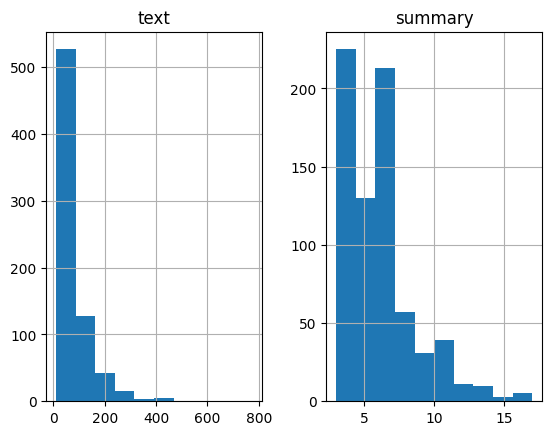

In [74]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in data['cleaned_text']:
    text_count.append(len(sent.split()))

for sent in data['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 10)
plt.show()

In [37]:
# Check how much % of text have 0-250 words
cnt = 0
for i in data['cleaned_text']:
    if len(i.split()) <= 250:
        cnt = cnt + 1
print(cnt / len(data['cleaned_text']))

0.9682320441988951


In [42]:
# Check how much % of text have 0-20 words
cnt = 0
for i in data['cleaned_summary']:
    if len(i.split()) <= 15:
        cnt = cnt + 1
print(cnt / len(data['cleaned_summary']))

0.9930939226519337


In [43]:
# Model to summarize the text between 0-15 words for Summary and 0-250 words for Text
max_text_len = 250
max_summary_len = 15

## Step 4: Selecting Plausible Texts and Summaries

In [44]:
# Select the Summaries and Text which fall below max length

import numpy as np

cleaned_text = np.array(data['cleaned_text'])
cleaned_summary= np.array(data['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

post_pre.head(2)

,text,summary
0,these are by far the best muffin mix anywhere was purchasing them directly from krusteaz for while and then found them at shaws grocery stores in my area ma the last several times ve looked for th...,_START_ krusteaz oat bran muffin mix _END_
1,my dogs love these and they smell so good have been tempted to try them bought the chicken variety they are way small so great for training purposes so that you don overfeed your dog in the proces...,_START_ they smell soooo yummy _END_


In [64]:
post_pre.sample(5)

,text,summary
226,taste is good received the product on oct 22nd 2009 but all 12 bags expires on nov 29th 2009 only 38 days to eat them all or give away will not order again.,sostok _START_ buyer beware _END_ eostok
102,you can use hemp for just about anything it great for foods and skin and to do some alchemy recommend it to everyone.,sostok _START_ hemp is good. _END_ eostok
655,please do your research on pet foods and what is actually good for your dogs hills science diet is horrible food filled with horrible ingredients they charge an outrageous price because it the #1 ...,sostok _START_ please avoid _END_ eostok
2,i paid $8 for boxes with envelopes in each box_ thought it was steal at that price was also pleased when it tasted divine it gonna be sweet obviously so make mine with more water than package says...,sostok _START_ yum_mocha+cocoa_tasty _END_ eostok
182,i put one on each side of the busy buddy jack and it must taste good because my dog goes after it until she has loosened the jack enough to either chew off the ring or unscrew the jack exactly as ...,sostok _START_ works great _END_ eostok


In [45]:
# Add sostok and eostok

post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

post_pre.head(2)

,text,summary
0,these are by far the best muffin mix anywhere was purchasing them directly from krusteaz for while and then found them at shaws grocery stores in my area ma the last several times ve looked for th...,sostok _START_ krusteaz oat bran muffin mix _END_ eostok
1,my dogs love these and they smell so good have been tempted to try them bought the chicken variety they are way small so great for training purposes so that you don overfeed your dog in the proces...,sostok _START_ they smell soooo yummy _END_ eostok


## Step 5: Tokenizing the Text

In [46]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [47]:
# Tokenize the text to get the vocab count
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [48]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  77.44136460554371


In [49]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 1059


In [50]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 89.74630021141648
Size of vocabulary in Y = 98


## Step 6: Removing Empty Texts and Summaries

In [51]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens

ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [52]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Step 7: Creating the Model

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 250, 200)             211800    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 250, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

## Step 8: Training the Model

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [56]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=256,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
5/5 [==============================] - 31s 3s/step - loss: 3.3972 - val_loss: 2.3443
Epoch 2/50
5/5 [==============================] - 14s 2s/step - loss: 1.5356 - val_loss: 1.2411
Epoch 3/50
5/5 [==============================] - 13s 2s/step - loss: 1.1708 - val_loss: 1.1747
Epoch 4/50
5/5 [==============================] - 13s 2s/step - loss: 1.1229 - val_loss: 1.1434
Epoch 5/50
5/5 [==============================] - 13s 2s/step - loss: 1.1505 - val_loss: 1.1845
Epoch 6/50
5/5 [==============================] - 13s 2s/step - loss: 1.1006 - val_loss: 1.1075
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 1.0744 - val_loss: 1.1200
Epoch 8/50
5/5 [==============================] - 14s 3s/step - loss: 1.0625 - val_loss: 1.0746
Epoch 9/50
5/5 [==============================] - 13s 3s/step - loss: 1.0472 - val_loss: 1.1085
Epoch 10/50
5/5 [==============================] - 13s 3s/step - loss: 1.0194 - val_loss: 1.0424
Epoch 11/50
5/5 [======================

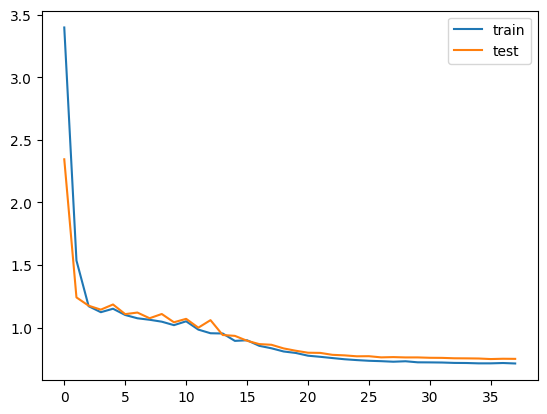

In [57]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [58]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


## Step 9: Generating Predictions

In [59]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [60]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [61]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [63]:
for i in range(0, 19):
    print('Review:', seq2text(x_tr[i]))
    print('Original summary:', seq2summary(y_tr[i]))
    print('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print('\n')

Review: i up eating this soup the picture on the can is what this soup used to look like this is there is almost no of any kind it is on the very bottom of the ingredient list next to salt br if you were looking for nice bowl of vegetarian this is for you 
Original summary: start end 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  start end


Review: these are the best cookies ve ever had so delicious that has customer here so fresh and tasty that could not stop eating them fresh ingredients and excellent price and the super fast shipping makes them stars definitely 
Original summary: start end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  start end


Review: great coffee in that doesn have starbucks and doesn have store that starbucks coffee beans which is the reason ordered from amazon 
Original summary: start great item end 
1/1 [==============================] - 0s 22ms/step
Predicted summary:  start end


Review: this is good ice